# Dataset declaration
Custom datasets loads the BRUSH samples in memory, each signal representing a sentence.

In [28]:
import os
from torch.utils.data import Dataset
import numpy as np
import cv2
import math
import pickle

class BrushDataset(Dataset):
    """The BRUSH dataset object is used to retrieve all samples from the BRUSH dataset
    This dataset retrives them as:
    Sample  = Offline image
    Label   = Online signal
    The loading of the dataset is special, as we retrieve only the label in memory and build
    the images at runtime.
    """
    brush_root: str
    display_stats: bool

    DRAW_COLOR_WHITE = 0
    DRAW_COLOR_BLACK = 255
    DRAW_COLOR_SIZE = 1

    signals: list[list]
    sentences: list[str]
    images: list

    size: int

    def __init__(self, brush_root, display_stats=False):
        self.brush_root = brush_root
        self.display_stats = display_stats

        self.signals = []
        self.sentences = []
        self.images = []

        self.load_samples()

    #Override
    def __len__(self):
        return len(self.images)

    #Override
    def __getitem__(self, idx):
        if idx >= self.size:
            raise Exception(f"Invalid index: Dataset of size {self.size} has no item at index {idx}")
        image = self.images[idx]
        label = self.signals[idx]
        return image, label

    def load_samples(self):
        """This function loads the samples forn disk, creatin the offline image in the process"""
        try:
            writer_ids = os.listdir(self.brush_root)
            total_writers = len(writer_ids)
            if self.display_stats:
                print(f"Loading {total_writers} writers")
        except Exception as e:
            print(f"Impossible to read folder {self.brush_root}")
            raise e
            
        i = 0
        for writer_id in writer_ids:
            i+=1
            if i>5:
                break
            writer_path = os.path.join(self.brush_root, writer_id)
            #Each drawin is present in three examplaries: n, n_resample20 and n_resample25
            #base dataloader selects default (10ms)
            drawing_ids = [name for name in os.listdir(writer_path) if not "_" in name]

            if self.display_stats:
                print(f"{i}/{total_writers}: Detected {len(drawing_ids)} drawings")

            for drawing_id in drawing_ids:
                full_path = os.path.join(writer_path, drawing_id)
                sentence, signal, char_label = self.load_signal(full_path)
                self.signals.append(signal)
                self.images.append(self.create_image(signal))
                self.sentences.append(sentence)

        self.size = len(self.images)
        if self.display_stats:
            print(f"Loaded {self.size} data points")        

    
    def load_signal(self, filepath: str) -> tuple[str, list, list]:
        """Load an online sinal from a filepath
        Args
        -----
            Filepath: The name of the file to load from
            
        Returns
        -----
            - str: Written sentence as string
            - list: Signal of x, y, penUp
            - list: List of one-hot vectors with same length as signal identifying charachter of point
        """
        with open(filepath, 'rb') as f:
            [sentence, signal, label] = pickle.load(f)
        
        return sentence, signal, label
    

    def create_image(self, signal: list[int, int, bool]):
        """Create the image associated with the given signal."""
        max_h =  int(math.ceil(max(signal[:, 0])))
        max_w = int(math.ceil(max(signal[:, 1])))
        canvas = np.ascontiguousarray(np.full((max_w, max_h), self.DRAW_COLOR_BLACK), dtype=np.uint8)

        #Draw lines from point (t-1) to current point (t) IFF the pen was not up. start with penup
        #as we start from point 0.
        draw_current_stroke = False
        for x, y, eos in signal:
            x,y = int(x), int(y)
            if draw_current_stroke:
                cv2.line(canvas, (last_x, last_y), (x, y), self.DRAW_COLOR_WHITE, self.DRAW_COLOR_SIZE) 
            last_x, last_y, draw_current_stroke = x, y, not eos
        
        return canvas

# Test dataset

Loading 170 writers
1/170: Detected 163 drawings
2/170: Detected 163 drawings
3/170: Detected 162 drawings
4/170: Detected 162 drawings
5/170: Detected 164 drawings
Loaded 814 data points
Size of dataset: 814


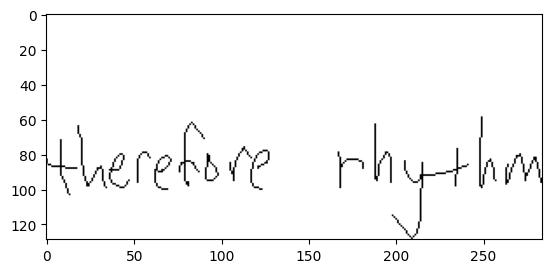

In [30]:
import matplotlib.pyplot as plt
import random

BRUSH_ROOT = "../data/handwriting/refined_BRUSH/BRUSH"

dataset = BrushDataset(brush_root=BRUSH_ROOT, display_stats=True)

print(f"Size of dataset: {dataset.size}")